# AnyoneAI - Project II

# Making Predictions with NBA data

In our first project, we learned how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using the Scikit Learn library

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## 1. Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

In [280]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")

Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

In [281]:
pd.set_option('display.max_columns', None)
data.head()

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134,18.4,7.2,5.1,0.8,0.4,0.5,2711280,"23 years, 0 months, 0 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,9,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,"29 years, 1 months, 30 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,5,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,"25 years, 2 months, 1 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,1,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,"21 years, 8 months, 9 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,16,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,"37 years, 2 months, 0 days"


<AxesSubplot:xlabel='BLK', ylabel='SALARY'>

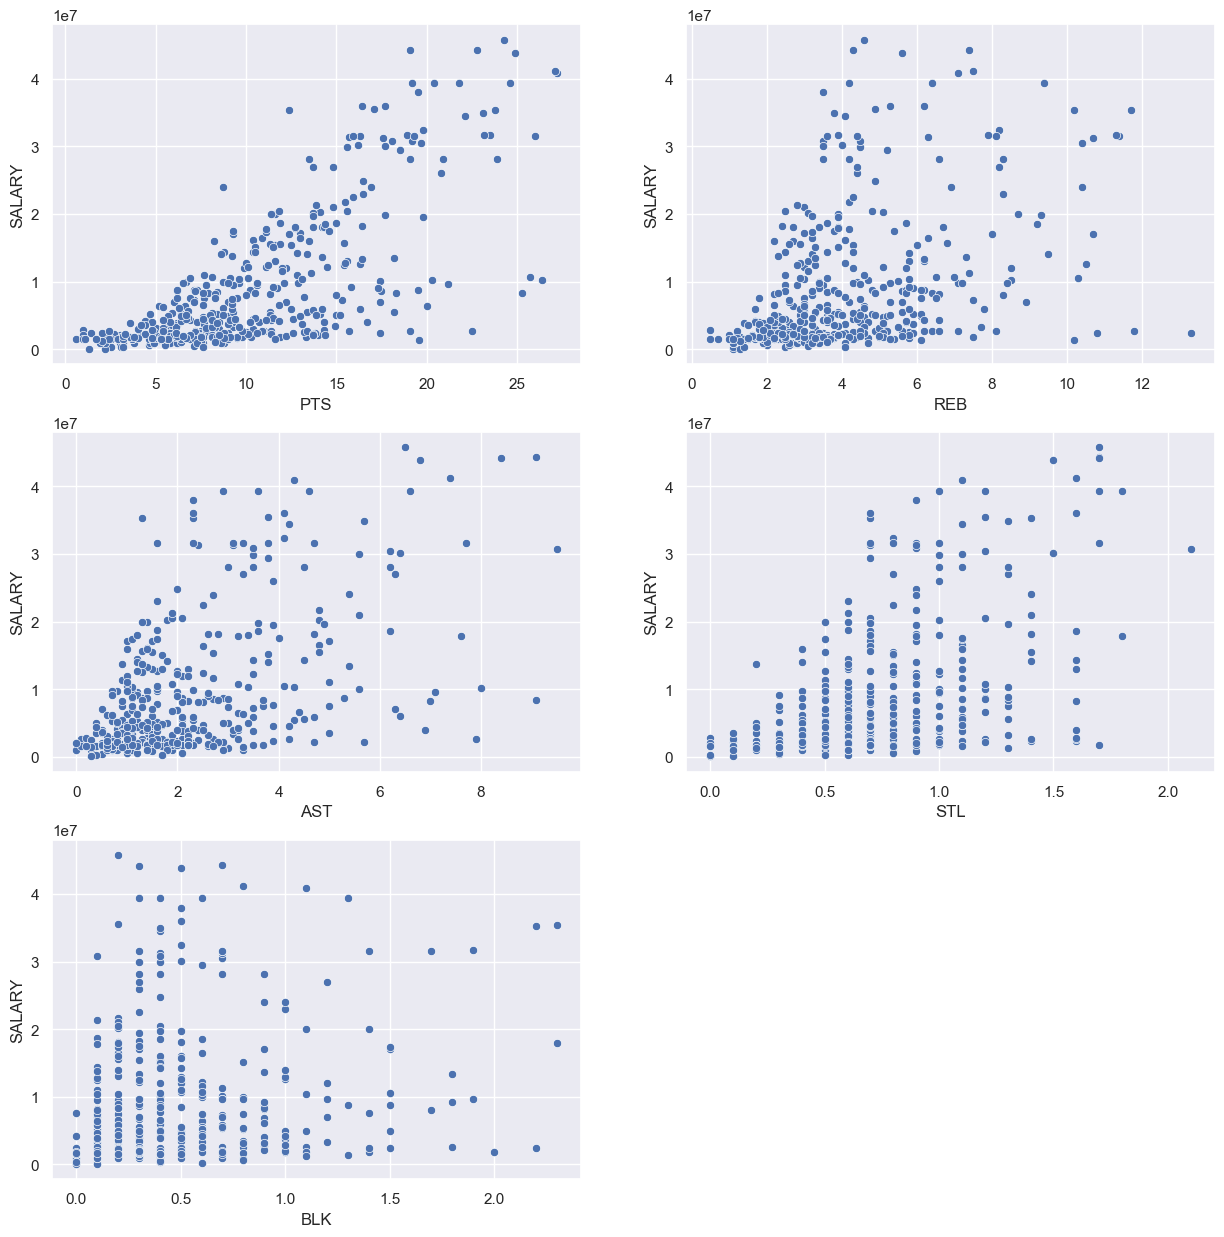

In [282]:
# "PTS", "REB", "AST","STL","BLK"
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
sns.scatterplot(x='PTS', y='SALARY', data=data)
plt.subplot(3,2,2)
sns.scatterplot(x='REB', y='SALARY', data=data)
plt.subplot(3,2,3)
sns.scatterplot(x='AST', y='SALARY', data=data)
plt.subplot(3,2,4)
sns.scatterplot(x='STL', y='SALARY', data=data)
plt.subplot(3,2,5)
sns.scatterplot(x='BLK', y='SALARY', data=data)

<Figure size 1000x1000 with 0 Axes>

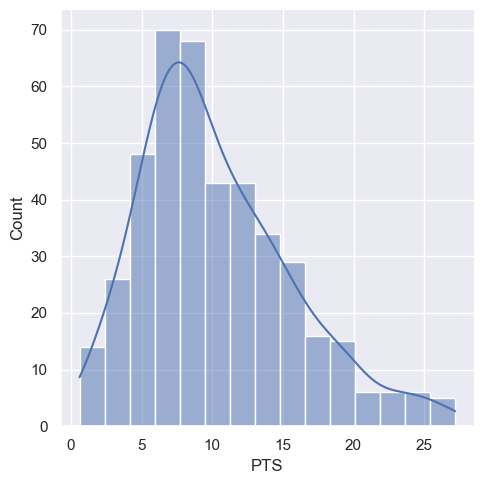

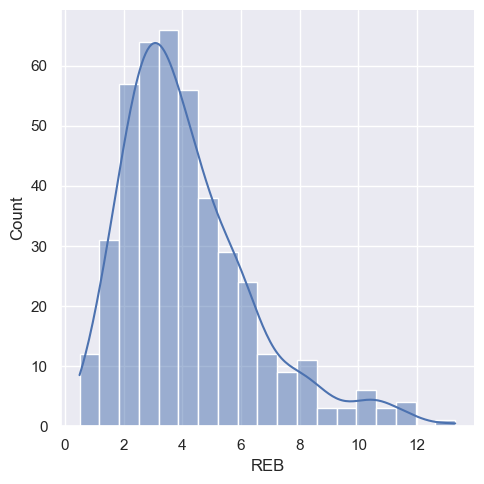

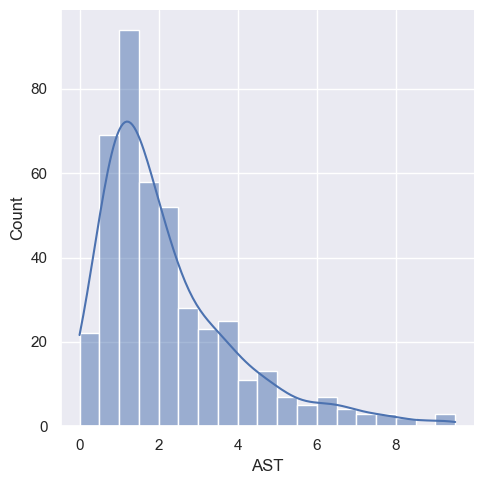

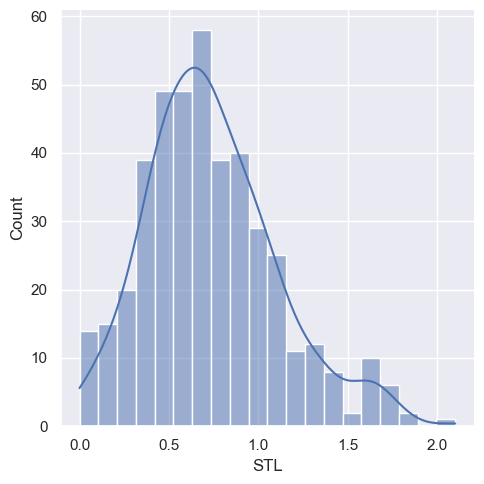

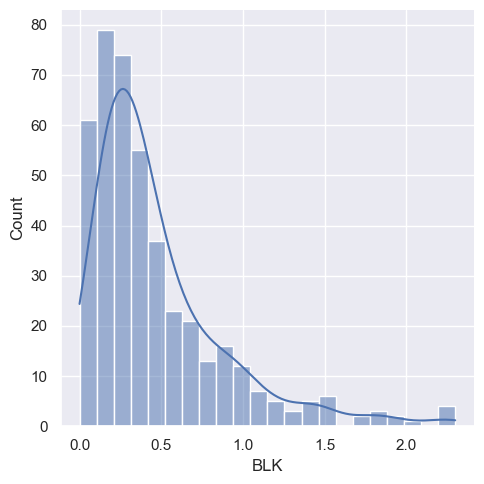

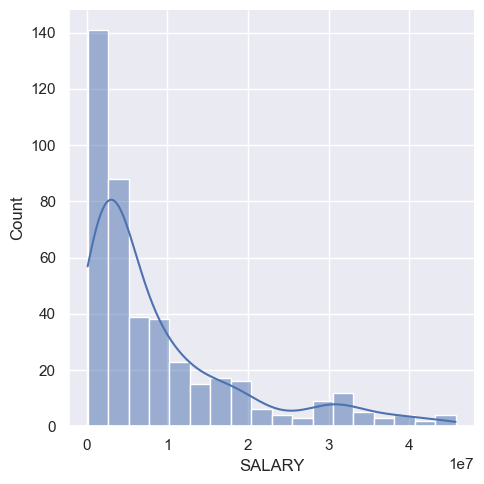

In [283]:
plt.figure(figsize=(10,10))


sns.displot(x='PTS', data=data, kde=True)

sns.displot(x='REB', data=data, kde=True)

sns.displot(x='AST', data=data, kde=True)

sns.displot(x='STL', data=data, kde=True)

sns.displot(x='BLK', data=data, kde=True)

sns.displot(x='SALARY', data=data, kde=True)


1.2. What can we say about these distributions?

In the scatter plot it can be seen that PTS, REB and AST are the ones that most resemble a linear correlation. Although these last two with much more variance, these three variables present a leptokurtic kurtosis, this means that they have a high degree of concentration of points around the measures of central tendency. They also have slight positive asymmetries, more noticeable for the AST variable.

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

**Note:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

In [284]:
data.columns

Index(['PERSON_ID', 'PLAYER_NAME', 'TEAM_NAME', 'POSITION', 'HEIGHT', 'WEIGHT',
       'COUNTRY', 'BIRTHDATE', 'SEASON_EXP', 'DRAFT_NUMBER', 'GP', 'MIN',
       'PTS', 'REB', 'AST', 'STL', 'BLK', 'SALARY', 'AGE'],
      dtype='object')

In [285]:
seed = 22

In [286]:
# TODO: Put here your features
X = data.drop(['SALARY'], axis=1).copy()
# TODO: Put here your labels
y = data.SALARY

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

*Don't change anything in this cell, just make it run correctly*

In [287]:
if X.SEASON_EXP[322] == 7 and y[255] == 1517981:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

if X.shape == (429, 18) and y.shape == (429,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!
Success!


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [288]:
class BaselineModel():
  """
  A baseline model that always returns the same value, the mean of the 
  players salary in the train data
  """
  
  def fit(self, y_train):
    """
    Fit the training data. 
    
    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
    """
    self.y_train_avg = np.mean(y_train)
  
  def predict(self, X):
    """
    Predict salaries 
    
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the 
        
    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to 
        the mean salary calculated in fit()
    """    
    return np.full(len(X), self.y_train_avg)

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [289]:
blm = BaselineModel()
blm.fit(y_train)

In [290]:
blm.predict(X)

array([8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329, 8740486.37609329, 8740486.37609329,
       8740486.37609329,

In [291]:
baseline_mae = mean_absolute_error(y, blm.predict(X))
baseline_mae

7399850.993074953

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

First I will perform a pair plot to have a graphical representation of all the features and how they are related to the target.
Below we can see that the features that best correlate are "MIN" and "PTS", but let's check it in a quantitative way.

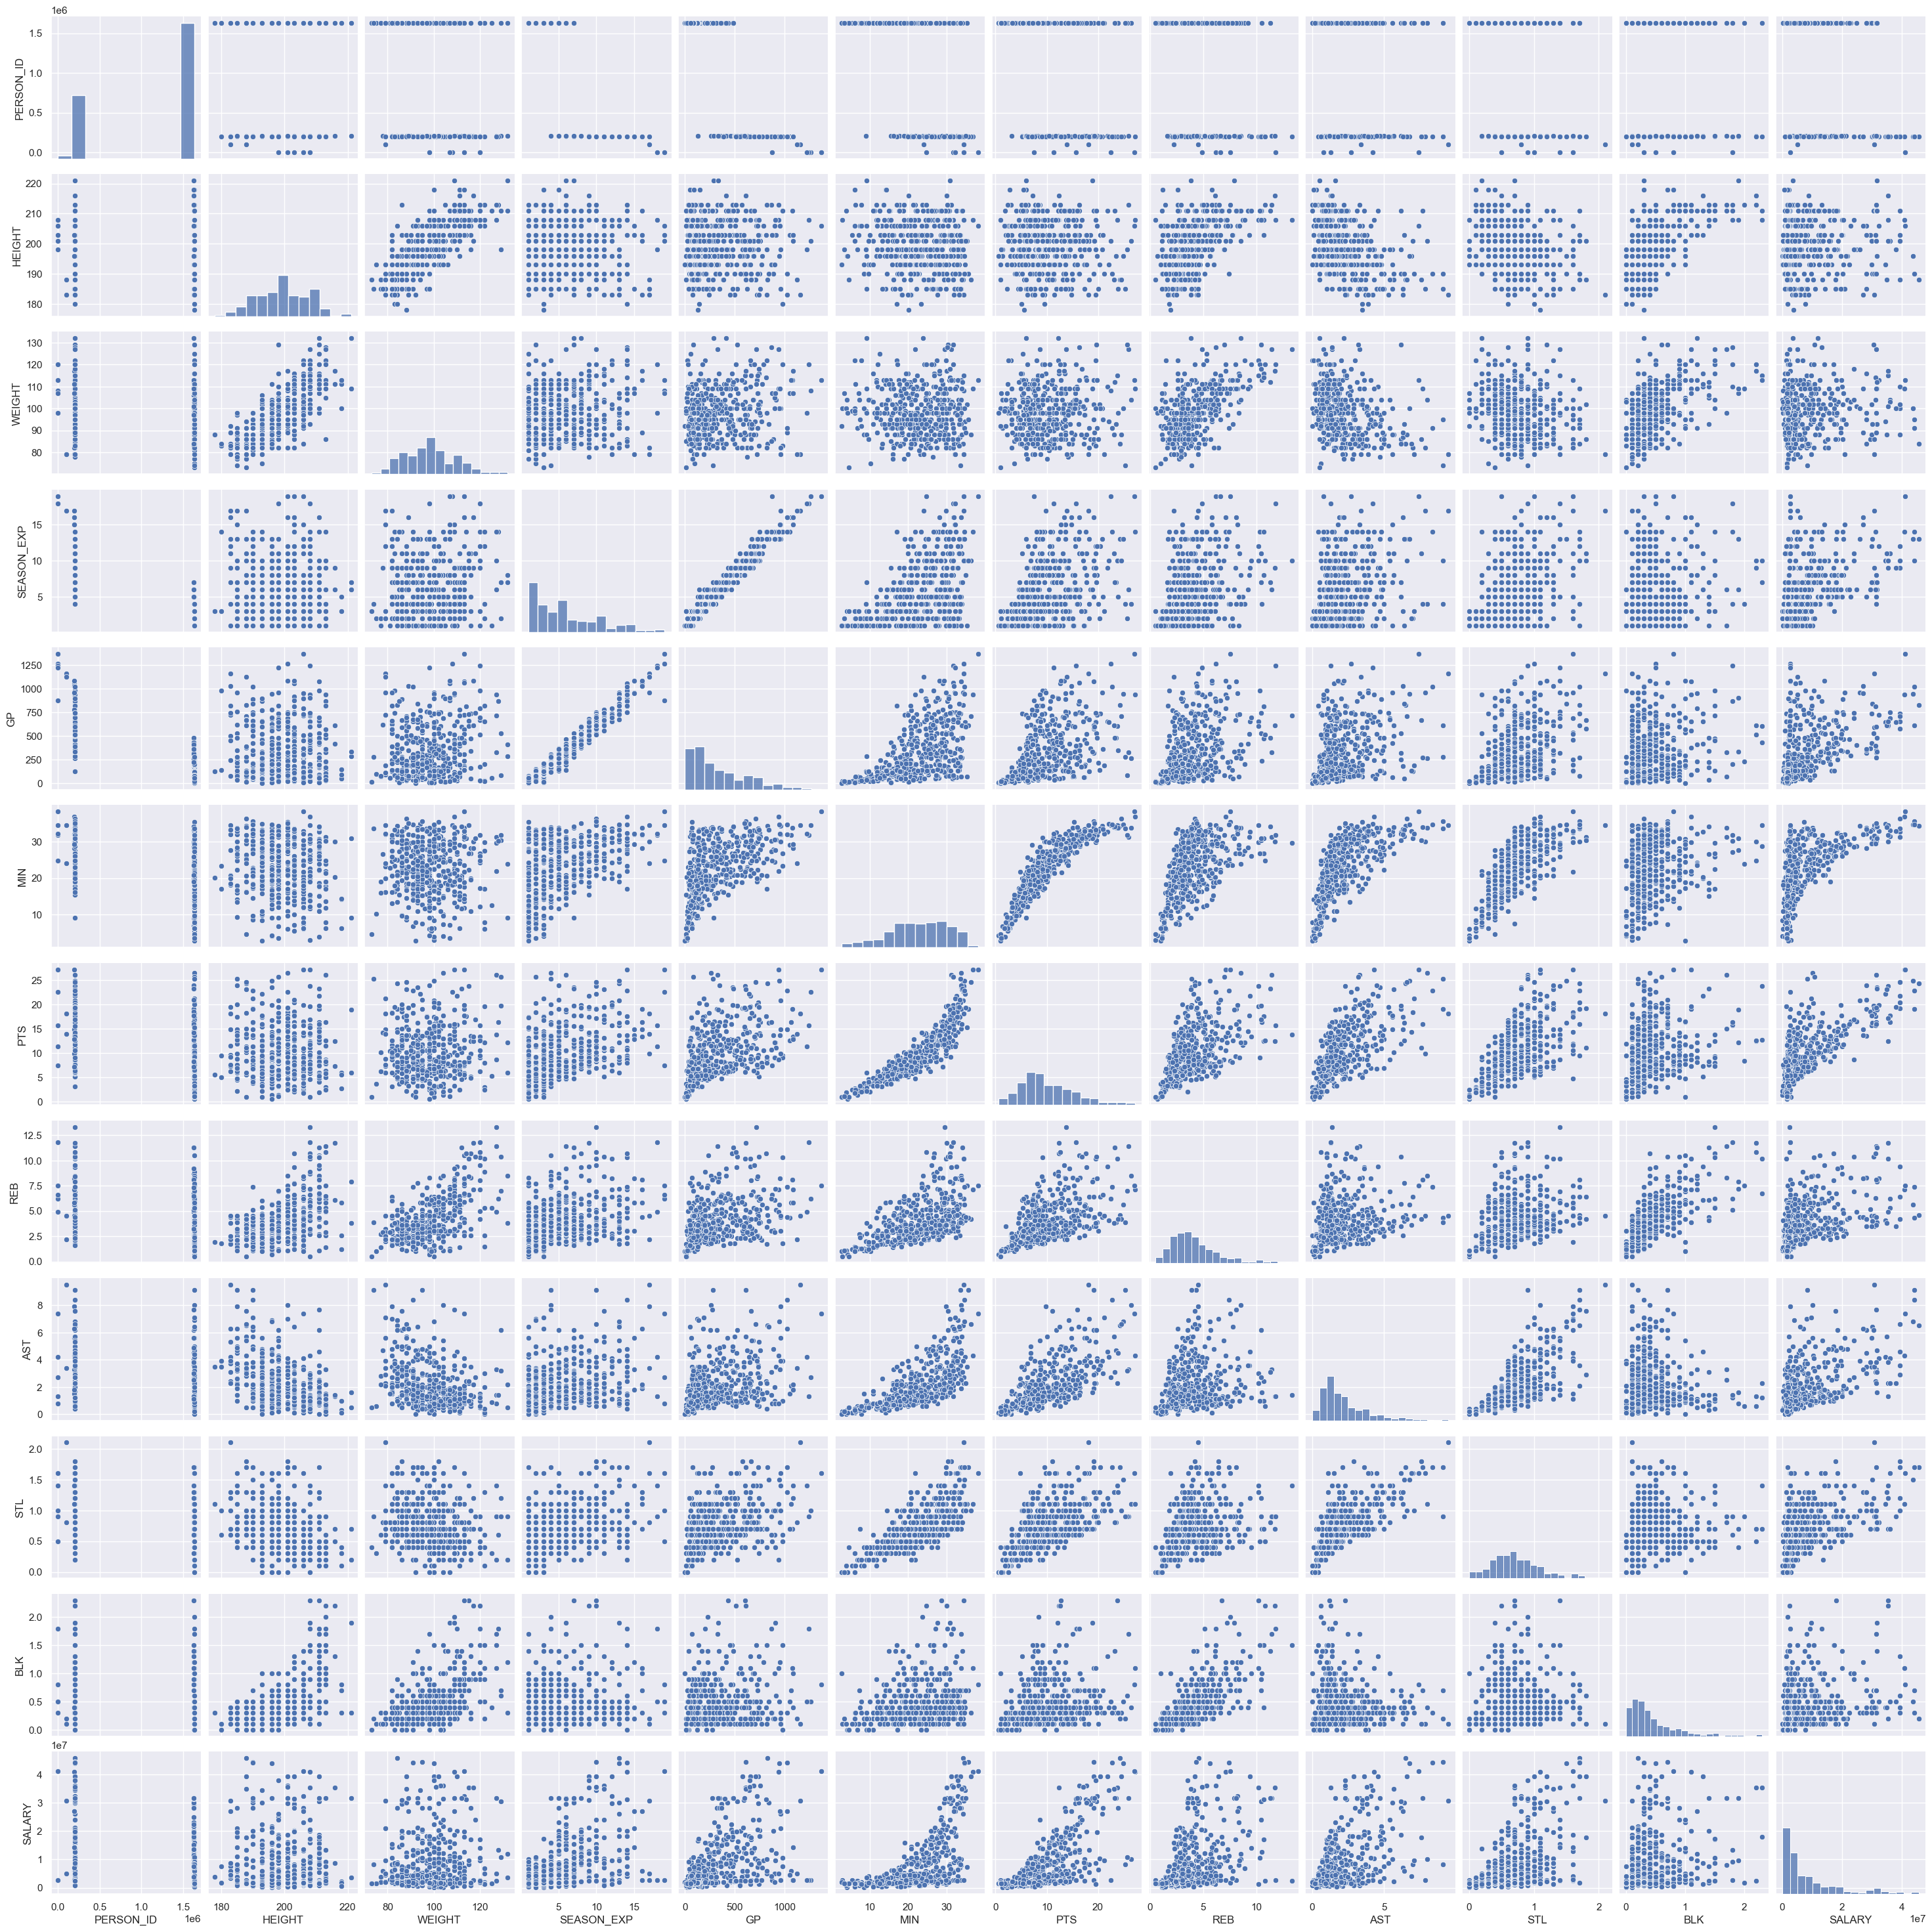

In [292]:
sns.pairplot(data);

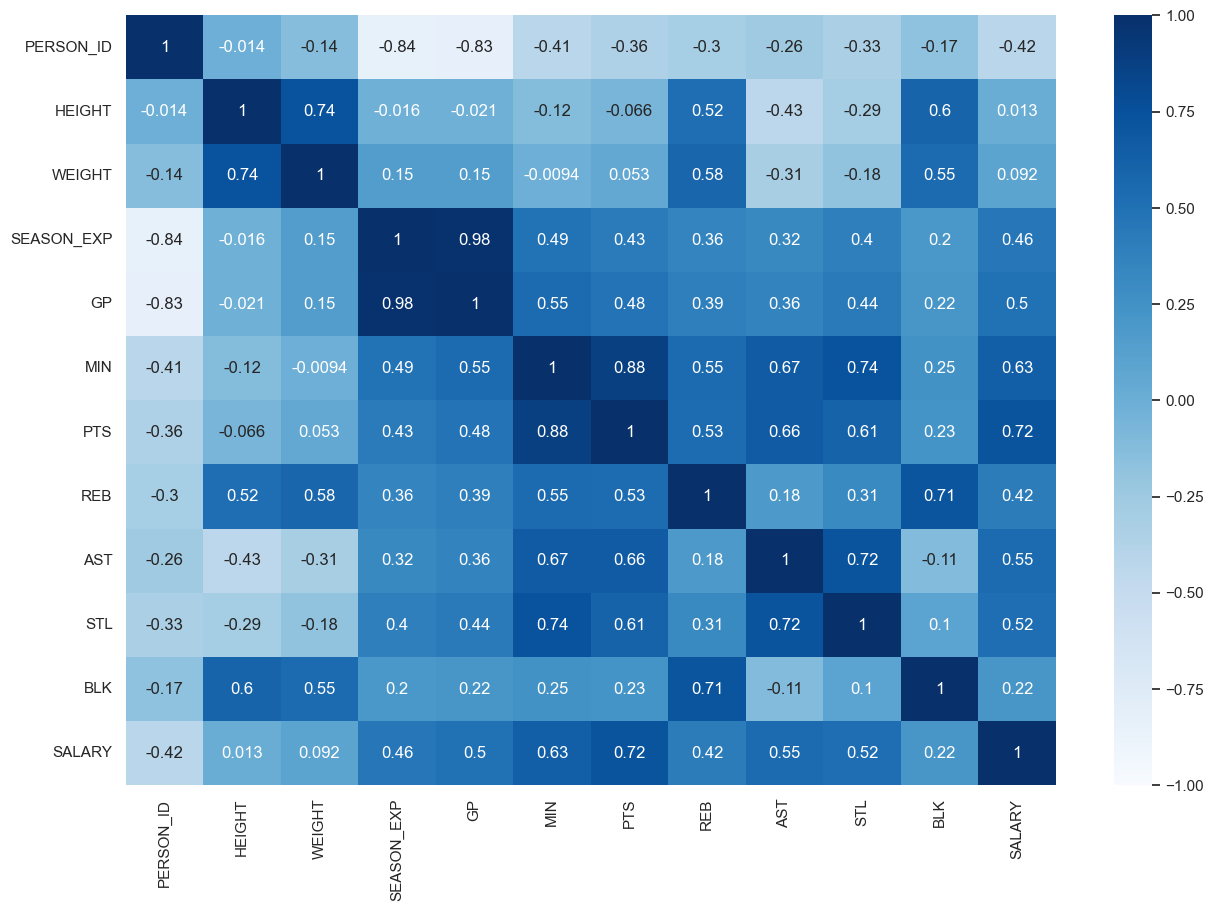

In [293]:
sns.set(rc={"figure.figsize":(15,10)})
sns.heatmap(data.corr(), annot=True, vmin=-1 ,  cmap='Blues');

We will choose the feature "PTS" that has a better correlation with respect to the target

In [294]:
# Define the target and the feature
X = data[['PTS']]
y = data.SALARY

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [295]:
# Instantiate the model
sgd = SGDRegressor(random_state=seed)

# fit model
sgd.fit(X_train, y_train)

default_mae = mean_absolute_error(y_test, sgd.predict(X_test))

print(f'MAE error on test set: {default_mae}')

MAE error on test set: 5360922.967127007


1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [296]:
# de mas 
X = data[['PTS']]
y = data.SALARY

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

In [297]:
from itertools import product

In [298]:
# data frames params
def search_best_hyperparameters(max_iter, eta0):
    hyperparameters = product(max_iter, eta0)
    mae_list = []
    
  # Complete your code here
    for m,e in hyperparameters:
        model = SGDRegressor(max_iter=m, eta0=e, random_state=22)
        model.fit(X_train, y_train)
        best_mae = mean_absolute_error(y_test, model.predict(X_test))
        mae_list.append((best_mae, m,e))
        mae_df = pd.DataFrame(mae_list, columns=['Mae', 'max_iter', 'eta0'])
        here = mae_df[mae_df['Mae'] == mae_df['Mae'].min()]
        here_mae = here.iloc[0][0]
        here_maxiter = here.iloc[0][1]
        here_eta = here.iloc[0][2]
        
        result = {
    "hyperparameters": {"max_iter": here_maxiter, "eta0": here_eta}, 
    "mae": here_mae
  }
    return result

In [299]:
# Example list of hyperparameters values
max_iter = [1000, 1000000] # bajar max iter
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0)
print(result)

{'hyperparameters': {'max_iter': 1000.0, 'eta0': 0.01}, 'mae': 5360922.967127007}


In [300]:
best_mae = result['mae']

1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [301]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")

Mean Absolute Error for each model:
Baseline: 7399850.993074953
Default SGDRegressor: 5360922.967127007
Best SGDRegressor: 5360922.967127007


### Multivariable Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index) and name it mv_regression_df:

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [302]:
# TODO: Complete here
mv_regression_df = data[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]].set_index(data["PERSON_ID"]).copy()

*Don't change anything in this cell, just make it run correctly*

In [303]:
if mv_regression_df.shape == (429, 8):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [304]:
# Check the unique values
mv_regression_df["DRAFT_NUMBER"].unique()

array(['20', '12', '14', '30', '2', '17', '21', '22', '15', '51', '3',
       '23', 'Undrafted', '9', '1', '27', '6', '46', '7', '4', '40', '53',
       '48', '25', '19', '42', '18', '35', '31', '44', '39', '13', '11',
       '28', '10', '36', nan, '45', '43', '33', '8', '49', '32', '24',
       '41', '5', '34', '38', '29', '52', '26', '37', '47', '55', '54',
       '50', '16', '58'], dtype=object)

In [305]:
# Replace the "undrafted" strings to int dtype, I choose 62 due is greater than 60 (the boundary of predeterminated bins)
mv_regression_df["DRAFT_NUMBER"] = mv_regression_df["DRAFT_NUMBER"].replace("Undrafted", 62)

In [306]:
# Check the NaN values
mv_regression_df["DRAFT_NUMBER"].isnull().sum()

3

In [307]:
# We impute the NaN values with the most frequent value
mv_regression_df["DRAFT_NUMBER"] = mv_regression_df["DRAFT_NUMBER"].fillna(62)

In [308]:
# We convert the draf number column as a int64 dtype 
mv_regression_df["DRAFT_NUMBER"] = mv_regression_df["DRAFT_NUMBER"].astype('int64')

In [309]:
# Bining the draf number column adding draft column 
bins = [1,15,30,60,70]
labels = ["firstround_lottery", "firstround_non_lottery", "second_round", "undrafted"]
mv_regression_df["DRAFT"] = pd.cut(mv_regression_df["DRAFT_NUMBER"], bins=bins, labels=labels)
mv_regression_df

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,SALARY,DRAFT
PERSON_ID,,,,,,,,,
1630173,7.2,5.1,0.8,0.5,2,Forward,20,2711280,firstround_non_lottery
203500,9.3,8.0,1.5,0.9,9,Center,12,17073171,firstround_lottery
1628389,13.5,8.3,3.5,0.9,5,Center,14,28103550,firstround_lottery
1630583,4.1,2.7,0.7,0.3,1,Forward,30,1994520,firstround_non_lottery
200746,19.1,8.1,1.9,1.1,16,Center,2,2641691,firstround_lottery
...,...,...,...,...,...,...,...,...,...
1626153,7.2,3.2,3.0,0.4,7,Guard,20,8526316,firstround_non_lottery
201152,12.8,5.8,1.8,0.4,15,Forward,12,14190000,firstround_lottery
1629027,25.3,3.9,9.1,0.2,4,Guard,5,8326471,firstround_lottery


*Don't change anything in this cell, just make it run correctly*

In [310]:
if mv_regression_df["DRAFT"].iloc[34] == 'firstround_lottery' and mv_regression_df["DRAFT"].iloc[105] == 'second_round':
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.12. Encode the categorical features: DRAFT, POSITION

In [311]:
draft_dummy = pd.get_dummies(mv_regression_df["DRAFT"], prefix="DRAFT", drop_first=True)
draft_dummy.head()

,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted
PERSON_ID,,,
1630173,1,0,0
203500,0,0,0
1628389,0,0,0
1630583,1,0,0
200746,0,0,0


In [312]:
mv_regression_df = mv_regression_df.join(draft_dummy)

In [313]:
position_dummy = pd.get_dummies(mv_regression_df["POSITION"], prefix="POSITION", drop_first=True)
position_dummy.head()

,POSITION_Forward,POSITION_Guard
PERSON_ID,,
1630173,1,0
203500,0,0
1628389,0,0
1630583,1,0
200746,0,0


In [314]:
mv_regression_df = mv_regression_df.join(position_dummy)

In [315]:
mv_regression_df

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,SALARY,DRAFT,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Forward,POSITION_Guard
PERSON_ID,,,,,,,,,,,,,,
1630173,7.2,5.1,0.8,0.5,2,Forward,20,2711280,firstround_non_lottery,1,0,0,1,0
203500,9.3,8.0,1.5,0.9,9,Center,12,17073171,firstround_lottery,0,0,0,0,0
1628389,13.5,8.3,3.5,0.9,5,Center,14,28103550,firstround_lottery,0,0,0,0,0
1630583,4.1,2.7,0.7,0.3,1,Forward,30,1994520,firstround_non_lottery,1,0,0,1,0
200746,19.1,8.1,1.9,1.1,16,Center,2,2641691,firstround_lottery,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626153,7.2,3.2,3.0,0.4,7,Guard,20,8526316,firstround_non_lottery,1,0,0,0,1
201152,12.8,5.8,1.8,0.4,15,Forward,12,14190000,firstround_lottery,0,0,0,1,0
1629027,25.3,3.9,9.1,0.2,4,Guard,5,8326471,firstround_lottery,0,0,0,0,1


*Don't change anything in this cell, just make it run correctly*

In [316]:
if mv_regression_df["DRAFT_firstround_non_lottery"].iloc[134] == 1 and mv_regression_df["POSITION_Forward"].iloc[205] == 0:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


#### Modeling

1.13. Split the dataset into train and test. 


**Note 1:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

**Note 2:** Remember to drop `DRAFT_NUMBER` column if you haven't done that before

In [317]:
mv_regression_df.columns

Index(['PTS', 'REB', 'AST', 'BLK', 'SEASON_EXP', 'POSITION', 'DRAFT_NUMBER',
       'SALARY', 'DRAFT', 'DRAFT_firstround_non_lottery', 'DRAFT_second_round',
       'DRAFT_undrafted', 'POSITION_Forward', 'POSITION_Guard'],
      dtype='object')

In [318]:
mv_regression_df.drop(["DRAFT_NUMBER"], axis=1, inplace=True)

In [319]:
features = ['PTS', 'REB', 'AST', 'BLK', 'SEASON_EXP', 'SALARY',
       'DRAFT_firstround_non_lottery', 'DRAFT_second_round', 'DRAFT_undrafted',
       'POSITION_Forward', 'POSITION_Guard']

In [320]:
# TODO: Put here your features
X = mv_regression_df[features]
# TODO: Put here your labels
y = mv_regression_df['SALARY']

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

*Don't change anything in this cell, just make it run correctly*

In [321]:
if X.BLK.iloc[353] == 0.1 and y.iloc[400] == 8729020:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next).

In [322]:
from sklearn.preprocessing import StandardScaler

In [323]:
scaler = StandardScaler()

In [324]:
numerical_columns = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]

In [325]:
mv_regression_df[numerical_columns] = scaler.fit_transform(mv_regression_df[numerical_columns])

In [326]:
mv_regression_df.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,SALARY,DRAFT,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Forward,POSITION_Guard
PERSON_ID,,,,,,,,,,,,,
1630173,-0.575844,0.431919,-0.812524,0.048257,-0.918350,Forward,2711280,firstround_non_lottery,1,0,0,1,0
203500,-0.184609,1.752191,-0.406802,1.022471,0.758127,Center,17073171,firstround_lottery,0,0,0,0,0
1628389,0.597862,1.888771,0.752402,1.022471,-0.199860,Center,28103550,firstround_lottery,0,0,0,0,0
1630583,-1.153382,-0.660720,-0.870484,-0.438851,-1.157847,Forward,1994520,firstround_non_lottery,1,0,0,1,0
200746,1.641156,1.797717,-0.174962,1.509579,2.434605,Center,2641691,firstround_lottery,0,0,0,0,0


1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [327]:
max_iter_2 = [1000,10000,100000,1000000]
eta0_2 = [0.0001, 0.0001, 0.001, 0.01, 0.1]
search_best_hyperparameters(max_iter_2, eta0_2)

{'hyperparameters': {'max_iter': 1000.0, 'eta0': 0.0001},
 'mae': 1.1662391295539921e+20}

1.16. How did the model performed compared to our univariate models? 

Perform much better than with the univariate model

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [328]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5, 10]

In [329]:
from sklearn.tree import DecisionTreeRegressor

In [330]:
def search_best_hyperparameters_2(max_depth, min_samples_leaf, max_features):
    hyperparameters_2 = product(max_depth, min_samples_leaf, max_features)
    mae_list_2 = []
    for m,i,a in hyperparameters_2:
        model_2 = DecisionTreeRegressor(max_depth=m, min_samples_leaf=i, max_features=a, random_state=22)
        model_2.fit(X_train, y_train)
        best_mae_2 = mean_absolute_error(y_test, model_2.predict(X_test))
        mae_list_2.append((best_mae_2, m,i,a))
        mae_df_2 = pd.DataFrame(mae_list_2, columns=['Mae', 'max_depth', 'min_samples_leaf', 'max_features'])
        here_2 = mae_df_2[mae_df_2['Mae'] == mae_df_2['Mae'].min()]
        here_mae_2 = here_2.iloc[0][0]
        here_max_depth = here_2.iloc[0][1]
        here_min_samples_leaf = here_2.iloc[0][2]
        here_max_features = here_2.iloc[0][3]
        
        result_2 = {
    "hyperparameters": {"max_depth": here_max_depth, "min_samples_leaf": here_min_samples_leaf, 'max_features':here_max_features}, 
    "mae": here_mae_2
  }
    return result_2

In [331]:
dtr_mae = search_best_hyperparameters_2(max_depth, min_samples_leaf, max_features)
dtr_mae

{'hyperparameters': {'max_depth': 10.0,
  'min_samples_leaf': 2.0,
  'max_features': 10.0},
 'mae': 282413.5145348837}

1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [332]:
best_dtr = dtr_mae['mae']
print(f'Default: {default_mae.round(2)}')
print(f'SGD Regressor: {best_mae.round(2)}')
print(f'Decission Tree Regressor: {best_dtr.round(2)}')

Default: 5360922.97
SGD Regressor: 5360922.97
Decission Tree Regressor: 282413.51


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

Because the line that best fits the data is still bad due to its characteristics (it may be due to heteroscedasticity or variance) while the decision tree is more "pragmatic" and flexible when setting parameters.

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

Optimize hyperparameter tuning

## 2. Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1983 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1983_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [333]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1983_2017_dataset.csv", index_col=0)

In [334]:
all_nba_df.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,0.474,0.0,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,0.493,0.0,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,0.518,0.0,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,0.436,0.0,0.436,0.640,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,0.511,0.0,0.515,0.571,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0


In [335]:
all_nba_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season_id      14825 non-null  int64  
 1   player_id      14825 non-null  int64  
 2   player_season  14825 non-null  int64  
 3   player         14825 non-null  object 
 4   season         14825 non-null  object 
 5   season_start   14825 non-null  int64  
 6   team           14825 non-null  object 
 7   games          14825 non-null  int64  
 8   gamesstarted   14825 non-null  int64  
 9   mp             14825 non-null  float64
 10  fg_perc        14825 non-null  float64
 11  3p_perc        14825 non-null  float64
 12  2p_perc        14825 non-null  float64
 13  ft_perc        14825 non-null  float64
 14  trb            14825 non-null  float64
 15  ast            14825 non-null  float64
 16  stl            14825 non-null  float64
 17  blk            14825 non-null  float64
 18  tov   

In [336]:
all_nba_df.describe()

,season_id,player_id,player_season,season_start,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,7692.419292,1401.031838,5.218347,2001.034064,54.259966,26.067184,20.368209,0.439310,0.213769,0.459010,0.699923,3.572857,1.871433,0.674556,0.421167,1.255427,1.939204,8.257342,0.033457
std,4434.434514,812.455621,3.888109,10.179255,25.250798,29.621125,10.257796,0.094392,0.183338,0.099553,0.186416,2.563905,1.876222,0.481526,0.513631,0.816028,0.852881,6.010045,0.179833
min,0.000000,0.000000,1.000000,1979.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3854.000000,689.000000,2.000000,1993.000000,35.000000,0.000000,11.800000,0.403000,0.000000,0.427000,0.647000,1.700000,0.600000,0.300000,0.100000,0.600000,1.300000,3.600000,0.000000
50%,7694.000000,1408.000000,4.000000,2002.000000,62.000000,11.000000,19.700000,0.444000,0.257000,0.469000,0.742000,2.900000,1.300000,0.600000,0.300000,1.100000,1.900000,6.700000,0.000000
75%,11537.000000,2096.000000,8.000000,2010.000000,77.000000,52.000000,29.000000,0.486000,0.355000,0.505000,0.809000,4.800000,2.500000,0.900000,0.500000,1.700000,2.500000,11.700000,0.000000
max,15353.000000,2820.000000,21.000000,2017.000000,85.000000,83.000000,43.700000,1.000000,1.000000,1.000000,1.000000,18.700000,14.500000,3.700000,5.600000,5.800000,6.000000,37.100000,1.000000


In [337]:
seasons = all_nba_df['season'].nunique()
unique_players = all_nba_df['player'].nunique()

In [338]:
players_selected = all_nba_df.groupby(['all_nba'])['player'].count()

In [339]:
print(f'Numeber of seasons: {seasons}')
print(f'Numeber of unique players: {unique_players}')
print(f'Number of non selected: {players_selected[0]}')
print(f'Number of selected: {players_selected[1]}')

Numeber of seasons: 39
Numeber of unique players: 2701
Number of non selected: 14329
Number of selected: 496


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'.

**Note:** Assign your features to `X` variable and labels to `y`.



In [340]:
# TODO: Put here your features
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
# TODO: Put here your labels
y = all_nba_df['all_nba']

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

*Don't change anything in this cell, just make it run correctly*

In [341]:
if X.shape == (14825, 15) and y.shape == (14825,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [342]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [343]:
class BaselineModel_2():
  
  def fit(self, y_train):
    self.y_train_zero = 0
  
  def predict(self, X):
    return np.full(len(X), self.y_train_zero)

In [344]:
blm2 = BaselineModel_2()
blm2.fit(y_train)
y_pred = blm2.predict(X)

In [345]:
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9665430016863407


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

It tells us that the data is unbalanced and that this metric with data of these characteristics is not reliable.

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [346]:
numerical_features = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

In [347]:
#transform_test no fit --> fit only train
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [348]:
from sklearn.linear_model import LogisticRegression

In [349]:
lr = LogisticRegression()
lr.fit(X_train[numerical_features], y_train)
y_pred_lr = lr.predict(X_test[numerical_features])

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [350]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

In [351]:
print(f'Accuracy: {accuracy_lr}')
print(f'Precison: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1: {f1_lr}')

Accuracy: 0.4924114671163575
Precison: 0.058786741713570984
Recall: 1.0
F1: 0.11104548139397519


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [404]:
 def class_ecoding(train_df: pd.DataFrame, test_df: pd.DataFrame):
    train_df = pd.get_dummies(data=train_df, columns={'team'}, prefix="team", drop_first=True)
    test_df = pd.get_dummies(data=test_df, columns={'team'}, prefix="team", drop_first=True)
    return train_df, test_df

In [353]:
Encoding_train, Encoding_test = class_ecoding(X_train, X_test)

C:\Users\Cesan\AppData\Local\Temp\ipykernel_24152\529593003.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = pd.get_dummies(data=train_df, columns={'team'}, prefix="team", drop_first=True)
C:\Users\Cesan\AppData\Local\Temp\ipykernel_24152\529593003.py:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_df = pd.get_dummies(data=test_df, columns={'team'}, prefix="team", drop_first=True)


In [354]:
Encoding_test.isnull().sum()

games           0
gamesstarted    0
mp              0
fg_perc         0
3p_perc         0
2p_perc         0
ft_perc         0
trb             0
ast             0
stl             0
blk             0
tov             0
pf              0
pts             0
team_BOS        0
team_BRK        0
team_CHA        0
team_CHH        0
team_CHI        0
team_CHO        0
team_CLE        0
team_DAL        0
team_DEN        0
team_DET        0
team_GSW        0
team_HOU        0
team_IND        0
team_KCK        0
team_LAC        0
team_LAL        0
team_MEM        0
team_MIA        0
team_MIL        0
team_MIN        0
team_NJN        0
team_NOH        0
team_NOK        0
team_NOP        0
team_NYK        0
team_OKC        0
team_ORL        0
team_PHI        0
team_PHO        0
team_POR        0
team_SAC        0
team_SAS        0
team_SDC        0
team_SEA        0
team_TOR        0
team_TOT        0
team_UTA        0
team_VAN        0
team_WAS        0
team_WSB        0
dtype: int64

In [355]:
Encoding_test.head()

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,team_BOS,team_BRK,team_CHA,team_CHH,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_KCK,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NJN,team_NOH,team_NOK,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_SDC,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
539,33,0,10.2,0.354,0.000,0.359,0.469,2.5,0.6,0.5,0.4,0.7,1.8,2.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
11908,28,3,6.0,0.367,0.000,0.367,0.586,1.6,0.0,0.1,0.4,0.4,1.2,1.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6865,82,82,40.7,0.453,0.356,0.487,0.791,4.1,6.5,1.3,0.4,3.3,2.3,20.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7442,42,1,15.0,0.475,0.308,0.485,0.688,1.1,2.7,0.6,0.1,1.4,1.4,5.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6202,69,10,14.2,0.330,0.287,0.403,0.300,2.3,0.3,0.2,0.6,0.4,1.2,2.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [356]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, Encoding_test.shape)

(11860, 15) (2965, 15) (11860,) (2965,) (2965, 54)


#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [357]:
def search_best_hyperparameters_3(tol, C, max_iter):

    # Imports that We need
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score

    # We create a list with all the possible combinations between the hyperparameters
    lr_hyperparameters = product(tol, C, max_iter)

    f1_list = [] # list that We'll need

    for t,c,m in lr_hyperparameters:

        # Define the model with each posible hyperparameter and fit the model
        lr_model = LogisticRegression(tol=t, C=c, max_iter=m, random_state=22)
        lr_model.fit(Encoding_train, y_train)
        
        # Define the metrics
        best_f1 = f1_score(y_test, lr_model.predict(Encoding_test))
        lr_precision = precision_score(y_test, lr_model.predict(Encoding_test))
        lr_recall = recall_score(y_test, lr_model.predict(Encoding_test))

        # Append in a list each model output 
        f1_list.append((best_f1, lr_precision, lr_recall, t,c,m))

    # We create a dataframe that contains the data that we need  
    best_f1_df = pd.DataFrame(f1_list, columns=['F1', 'Precision', 'Recall', 'tol', 'C', 'max_iter'])
    
    # Filter the columns and rows that we need
    max_f1 = best_f1_df[best_f1_df['F1'] == best_f1_df['F1'].max()]
    max_f1 = max_f1.iloc[:1]

    return max_f1

In [358]:
tol = [0.001, 0.0001, 0.00001]
C = [0.5, 1, 1.5]
max_iter = [50, 100, 150]

In [359]:
best_hyp_lr = search_best_hyperparameters_3(tol=tol, C=C, max_iter=max_iter)

c:\Users\Cesan\miniconda3\envs\santireds\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Cesan\miniconda3\envs\santireds\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [360]:
best_hyp_lr

,F1,Precision,Recall,tol,C,max_iter
8,0.111177,0.05886,1.0,0.001,1.5,150


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [361]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [362]:
all_nba_2018_df.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
34,34,5,2,Alex Abrines,2018-19,2018,OKC,31,2,19.0,0.357,0.323,0.500,0.923,1.5,0.6,0.5,0.2,0.5,1.7,5.3
49,49,8,7,Quincy Acy,2018-19,2018,PHO,10,0,12.3,0.222,0.133,0.667,0.700,2.5,0.8,0.1,0.4,0.4,2.4,1.7
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,34,1,12.6,0.345,0.338,0.361,0.778,1.8,1.9,0.4,0.1,0.8,1.3,3.2
71,71,13,6,Steven Adams,2018-19,2018,OKC,80,80,33.4,0.595,0.000,0.596,0.500,9.5,1.6,1.5,1.0,1.7,2.6,13.9
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,82,28,23.3,0.576,0.200,0.588,0.735,7.3,2.2,0.9,0.8,1.5,2.5,8.9


In [363]:
all_nba_2018_df.shape

(530, 21)

In [364]:
all_nba_2018_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 34 to 15354
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season_id      530 non-null    int64  
 1   player_id      530 non-null    int64  
 2   player_season  530 non-null    int64  
 3   player         530 non-null    object 
 4   season         530 non-null    object 
 5   season_start   530 non-null    int64  
 6   team           530 non-null    object 
 7   games          530 non-null    int64  
 8   gamesstarted   530 non-null    int64  
 9   mp             530 non-null    float64
 10  fg_perc        530 non-null    float64
 11  3p_perc        530 non-null    float64
 12  2p_perc        530 non-null    float64
 13  ft_perc        530 non-null    float64
 14  trb            530 non-null    float64
 15  ast            530 non-null    float64
 16  stl            530 non-null    float64
 17  blk            530 non-null    float64
 18  tov    

In [365]:
all_nba_2018_selections.head()

,player_id,player,all_nba
34,5,Alex Abrines,0
49,8,Quincy Acy,0
70,10,Jaylen Adams,0
71,13,Steven Adams,0
79,15,Bam Adebayo,0


In [366]:
all_nba_2018_selections.shape

(530, 3)

In [367]:
all_nba_2018_selections.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 34 to 15354
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   player_id  530 non-null    int64 
 1   player     530 non-null    object
 2   all_nba    530 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 16.6+ KB


### Scaling and One Hot Encoding

In [368]:
def scaling_encoding_nba(all_nba_df: pd.DataFrame):

    # Train Scaling section 
    # Import and instance model
    from sklearn.preprocessing import RobustScaler
    rs = RobustScaler()
    # Define the numerical feature as a variable
    int_numerical_features = all_nba_df.select_dtypes('int64')
    float_numercial_features = all_nba_df.select_dtypes('float64')
    all_numercial_features = int_numerical_features.join(float_numercial_features)
    all_nba_df[all_numercial_features.columns] = rs.fit_transform(all_nba_df[all_numercial_features.columns])

    # Encoding section    
    all_nba_df = pd.get_dummies(data=all_nba_df, columns={'team'}, prefix="team", drop_first=True)

    return all_nba_df

In [369]:
all_nba_2018_df = scaling_encoding_nba(all_nba_2018_df)

C:\Users\Cesan\AppData\Local\Temp\ipykernel_24152\2145353155.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  all_nba_df = pd.get_dummies(data=all_nba_df, columns={'team'}, prefix="team", drop_first=True)


In [370]:
all_nba_2018_df.head(50)

,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_TOT,team_UTA,team_WAS
34,-0.990934,-0.981039,-0.333333,Alex Abrines,2018-19,0.0,-0.543478,-0.137143,-0.013423,-0.931429,-0.076404,0.00,1.039039,-0.551724,-0.394366,0.000000,-0.25,-0.410256,0.000000,-0.221498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
49,-0.988842,-0.978764,0.500000,Quincy Acy,2018-19,0.0,-1.000000,-0.182857,-0.463087,-2.474286,-1.784270,1.67,-0.300300,-0.206897,-0.281690,-0.666667,0.25,-0.512821,0.636364,-0.690554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
70,-0.988423,-0.977247,-0.500000,Jaylen Adams,2018-19,0.0,-0.478261,-0.160000,-0.442953,-1.068571,0.058427,-1.39,0.168168,-0.448276,0.338028,-0.166667,-0.50,-0.102564,-0.363636,-0.495114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71,-0.985773,-0.974972,0.333333,Steven Adams,2018-19,0.0,0.521739,1.645714,0.953020,1.788571,-2.979775,0.96,-1.501502,2.206897,0.169014,1.666667,1.75,0.820513,0.818182,0.899023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
79,-0.984657,-0.973455,-0.333333,Bam Adebayo,2018-19,0.0,0.565217,0.457143,0.275168,1.571429,-1.182022,0.88,-0.090090,1.448276,0.507042,0.666667,1.25,0.615385,0.727273,0.247557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80,-0.984518,-0.972696,-0.500000,Deng Adel,2018-19,0.0,-0.804348,-0.114286,-0.604027,-1.514286,-0.633708,-1.15,1.501502,-0.724138,-0.563380,-0.666667,-0.25,-0.615385,-0.909091,-0.690554,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
139,-0.976288,-0.965870,-0.500000,DeVaughn Akoon-Purcell,2018-19,0.0,-1.065217,-0.182857,-1.080537,-1.582857,-2.979775,0.00,-1.501502,-0.862069,-0.225352,-0.333333,-0.75,-0.615385,-1.000000,-0.781759,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
168,-0.972244,-0.962078,1.500000,LaMarcus Aldridge,2018-19,0.0,0.543478,1.668571,0.939597,0.920000,-0.840449,0.28,0.582583,2.103448,0.619718,0.000000,2.50,0.923077,0.454545,1.863192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
193,-0.968757,-0.955252,-0.500000,Rawle Alkins,2018-19,0.0,-1.000000,-0.160000,-0.483221,-1.205714,-0.732584,-1.30,-0.498498,-0.172414,0.000000,-0.666667,-0.75,-0.102564,-0.909091,-0.429967,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
248,-0.968617,-0.954494,-0.500000,Grayson Allen,2018-19,0.0,-0.391304,-0.137143,-0.557047,-0.714286,-0.076404,-0.57,0.000000,-0.862069,-0.338028,-0.500000,-0.25,0.000000,-0.454545,-0.182410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [371]:
all_nba_2018_df.isnull().sum()

season_id        0
player_id        0
player_season    0
player           0
season           0
season_start     0
games            0
gamesstarted     0
mp               0
fg_perc          0
3p_perc          0
2p_perc          0
ft_perc          0
trb              0
ast              0
stl              0
blk              0
tov              0
pf               0
pts              0
team_BOS         0
team_BRK         0
team_CHI         0
team_CHO         0
team_CLE         0
team_DAL         0
team_DEN         0
team_DET         0
team_GSW         0
team_HOU         0
team_IND         0
team_LAC         0
team_LAL         0
team_MEM         0
team_MIA         0
team_MIL         0
team_MIN         0
team_NOP         0
team_NYK         0
team_OKC         0
team_ORL         0
team_PHI         0
team_PHO         0
team_POR         0
team_SAC         0
team_SAS         0
team_TOR         0
team_TOT         0
team_UTA         0
team_WAS         0
dtype: int64

In [372]:
all_nba_2018_df.shape

(530, 50)

In [373]:
all_nba_2018_df.columns

Index(['season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'team_BOS', 'team_BRK', 'team_CHI', 'team_CHO', 'team_CLE', 'team_DAL',
       'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND', 'team_LAC',
       'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL', 'team_MIN', 'team_NOP',
       'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
       'team_SAC', 'team_SAS', 'team_TOR', 'team_TOT', 'team_UTA', 'team_WAS'],
      dtype='object')

In [374]:
Encoding_test.columns

Index(['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
       'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'team_BOS',
       'team_BRK', 'team_CHA', 'team_CHH', 'team_CHI', 'team_CHO', 'team_CLE',
       'team_DAL', 'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND',
       'team_KCK', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL',
       'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP', 'team_NYK',
       'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR', 'team_SAC',
       'team_SAS', 'team_SDC', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_VAN', 'team_WAS', 'team_WSB'],
      dtype='object')

In [375]:
def complete_columns(nba_df: pd.DataFrame):
    teams = ['team_BOS',
       'team_BRK', 'team_CHA', 'team_CHH', 'team_CHI', 'team_CHO', 'team_CLE',
       'team_DAL', 'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND',
       'team_KCK', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL',
       'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP', 'team_NYK',
       'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR', 'team_SAC',
       'team_SAS', 'team_SDC', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_VAN', 'team_WAS', 'team_WSB']

    # for loop
    team_list = []
    for i in teams:
        if i not in nba_df.columns:
            team_list.append(i)

    for t in team_list:
        nba_df[t] = np.full(len(nba_df), 0)
    
    return nba_df

In [376]:
all_nba_2018_df = complete_columns(all_nba_2018_df)

In [377]:
all_nba_2018_df.head()

,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_TOT,team_UTA,team_WAS,team_CHA,team_CHH,team_KCK,team_NJN,team_NOH,team_NOK,team_SDC,team_SEA,team_VAN,team_WSB
34,-0.990934,-0.981039,-0.333333,Alex Abrines,2018-19,0.0,-0.543478,-0.137143,-0.013423,-0.931429,-0.076404,0.00,1.039039,-0.551724,-0.394366,0.000000,-0.25,-0.410256,0.000000,-0.221498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49,-0.988842,-0.978764,0.500000,Quincy Acy,2018-19,0.0,-1.000000,-0.182857,-0.463087,-2.474286,-1.784270,1.67,-0.300300,-0.206897,-0.281690,-0.666667,0.25,-0.512821,0.636364,-0.690554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70,-0.988423,-0.977247,-0.500000,Jaylen Adams,2018-19,0.0,-0.478261,-0.160000,-0.442953,-1.068571,0.058427,-1.39,0.168168,-0.448276,0.338028,-0.166667,-0.50,-0.102564,-0.363636,-0.495114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71,-0.985773,-0.974972,0.333333,Steven Adams,2018-19,0.0,0.521739,1.645714,0.953020,1.788571,-2.979775,0.96,-1.501502,2.206897,0.169014,1.666667,1.75,0.820513,0.818182,0.899023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79,-0.984657,-0.973455,-0.333333,Bam Adebayo,2018-19,0.0,0.565217,0.457143,0.275168,1.571429,-1.182022,0.88,-0.090090,1.448276,0.507042,0.666667,1.25,0.615385,0.727273,0.247557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [378]:
all_nba_2018_df.shape

(530, 60)

In [379]:
all_nba_2018_df.drop(['season_id', 'player_id', 'player_season', 'player', 'season', 'season_start'], axis=1, inplace=True)

*Don't change anything in this cell, just make it run correctly*

In [380]:
if all_nba_2018_df.shape == (530, 54):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [381]:
lr_model = LogisticRegression(tol=0.001, C=1.5, max_iter=150, random_state=22)
lr_model.fit(Encoding_train, y_train)

LogisticRegression(C=1.5, max_iter=150, random_state=22, tol=0.001)

In [382]:
validation_f1 = f1_score(all_nba_2018_selections['all_nba'], lr_model.predict(all_nba_2018_df))
validation_prec = precision_score(all_nba_2018_selections['all_nba'], lr_model.predict(all_nba_2018_df))
validation_rec = recall_score(all_nba_2018_selections['all_nba'], lr_model.predict(all_nba_2018_df))

c:\Users\Cesan\miniconda3\envs\santireds\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\Cesan\miniconda3\envs\santireds\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\Cesan\miniconda3\envs\santireds\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [383]:
print(f'F1: {validation_f1}\nPrecision: {validation_prec}\nRecall: {validation_rec}')

F1: 0.6285714285714286
Precision: 0.55
Recall: 0.7333333333333333


2.12. Analyze the results, what do you think it is happening?

I think the model improved its performance predicting the TN and worsened a little predicting the TP

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [384]:
validation_proba = lr_model.predict_proba(all_nba_2018_df)

c:\Users\Cesan\miniconda3\envs\santireds\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [385]:
val_proba = pd.DataFrame(validation_proba[:,0], columns=['proba']).round(3)

In [386]:
all_nba_2018_df_copy = all_nba_2018_df.copy()

In [387]:
val_proba['ID'] = [i for i in range(530)]
all_nba_2018_df_copy['ID'] = [i for i in range(530)]

In [388]:
all_nba_2018_val_proba = pd.merge(all_nba_2018_df_copy, val_proba, on='ID')

In [389]:
all_nba_2018_val_proba

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_TOT,team_UTA,team_WAS,team_CHA,team_CHH,team_KCK,team_NJN,team_NOH,team_NOK,team_SDC,team_SEA,team_VAN,team_WSB,ID,proba
0,-0.543478,-0.137143,-0.013423,-0.931429,-0.076404,0.00,1.039039,-0.551724,-0.394366,0.000000,-0.25,-0.410256,0.000000,-0.221498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000
1,-1.000000,-0.182857,-0.463087,-2.474286,-1.784270,1.67,-0.300300,-0.206897,-0.281690,-0.666667,0.25,-0.512821,0.636364,-0.690554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000
2,-0.478261,-0.160000,-0.442953,-1.068571,0.058427,-1.39,0.168168,-0.448276,0.338028,-0.166667,-0.50,-0.102564,-0.363636,-0.495114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1.000
3,0.521739,1.645714,0.953020,1.788571,-2.979775,0.96,-1.501502,2.206897,0.169014,1.666667,1.75,0.820513,0.818182,0.899023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.977
4,0.565217,0.457143,0.275168,1.571429,-1.182022,0.88,-0.090090,1.448276,0.507042,0.666667,1.25,0.615385,0.727273,0.247557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.543478,1.668571,0.785235,-0.234286,-0.067416,-0.23,0.474474,0.206897,3.830986,0.666667,-0.25,2.974359,0.000000,1.576547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,525,0.883
526,-0.152174,0.891429,0.416107,1.285714,-0.525843,0.70,0.222222,1.275862,0.450704,0.500000,1.25,0.410256,1.454545,0.403909,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,526,0.998
527,-1.086957,-0.160000,-0.248322,1.080000,-2.979775,0.52,0.168168,0.310345,-0.338028,-0.500000,0.50,-0.205128,1.454545,0.091205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,527,1.000
528,0.065217,0.388571,-0.060403,1.308571,-2.979775,0.53,-0.270270,0.793103,-0.225352,-0.500000,0.25,0.102564,0.181818,0.104235,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,528,1.000


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [390]:
all_nba_2018_df_proba.sort_values(by=['proba'],ascending=False)

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_TOT,team_UTA,team_WAS,team_CHA,team_CHH,team_KCK,team_NJN,team_NOH,team_NOK,team_SDC,team_SEA,team_VAN,team_WSB,proba
503,0.543478,0.548571,0.335570,0.097143,0.373034,0.27,0.738739,-0.137931,1.126761,0.500000,-0.75,-0.102564,0.363636,-0.039088,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
70,-0.478261,-0.160000,-0.442953,-1.068571,0.058427,-1.39,0.168168,-0.448276,0.338028,-0.166667,-0.50,-0.102564,-0.363636,-0.495114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
250,-0.804348,-0.160000,0.181208,0.257143,1.262921,-0.43,0.168168,-0.137931,1.521127,0.500000,-0.25,0.512821,0.636364,0.377850,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.999998
454,-1.173913,-0.182857,-0.919463,-5.011429,-2.979775,-5.00,-1.501502,-0.896552,-0.732394,0.833333,-0.75,-0.410256,-1.545455,-0.781759,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.999998
34,-0.543478,-0.137143,-0.013423,-0.931429,-0.076404,0.00,1.039039,-0.551724,-0.394366,0.000000,-0.25,-0.410256,0.000000,-0.221498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.999997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,0.543478,1.668571,0.785235,-0.234286,-0.067416,-0.23,0.474474,0.206897,3.830986,0.666667,-0.25,2.974359,0.000000,1.576547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
15333,-0.152174,0.891429,0.416107,1.285714,-0.525843,0.70,0.222222,1.275862,0.450704,0.500000,1.25,0.410256,1.454545,0.403909,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
15334,-1.086957,-0.160000,-0.248322,1.080000,-2.979775,0.52,0.168168,0.310345,-0.338028,-0.500000,0.50,-0.205128,1.454545,0.091205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN
15350,0.065217,0.388571,-0.060403,1.308571,-2.979775,0.53,-0.270270,0.793103,-0.225352,-0.500000,0.25,0.102564,0.181818,0.104235,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [391]:
actually_selected = all_nba_2018_selections[all_nba_2018_selections['all_nba'] == 1]

In [392]:
as_ourpred_arr = lr_model.predict(all_nba_2018_df)

c:\Users\Cesan\miniconda3\envs\santireds\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [393]:
all_nba_2018_selections['ID'] = [i for i in range(530)]

In [394]:
as_ourpred_df = pd.DataFrame(as_ourpred_arr, columns=['predict'])
as_ourpred_df['ID'] = [i for i in range(530)]

In [395]:
our_prediction = pd.merge(all_nba_2018_selections, as_ourpred_df, on='ID')

In [402]:
our_prediction[(our_prediction['all_nba'] == 1) & (our_prediction['predict'] == 0)]

,player_id,player,all_nba,ID,predict
123,570,Stephen Curry,1,123,0
182,884,Paul George,1,182,0
201,979,Blake Griffin,1,201,0
304,1511,Damian Lillard,1,304,0


In [403]:
our_prediction[(our_prediction['all_nba'] == 0) & (our_prediction['predict'] == 1)]

,player_id,player,all_nba,ID,predict
7,30,LaMarcus Aldridge,0,7,1
39,179,Bradley Beal,0,39,1
88,405,Clint Capela,0,88,1
125,587,Anthony Davis,0,125,1
146,682,Andre Drummond,0,146,1
229,1131,Jrue Holiday,0,229,1
447,2267,Ben Simmons,0,447,1
479,2501,Karl-Anthony Towns,0,479,1
491,2572,Nikola Vucevic,0,491,1


2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [489]:
class AllNbaSingleSeasonClassifier():
  def __init__(self, model):
    """
    Class constructor
    
    Parameters
    ----------
    model: BaseEstimator
      a Scikit learn estimator
    """
    self._model = model
      
  def predict(self, X):
    """
    Predicts all nba selections. This classifier will limit the number
    of positive instances to 15
    
    Parameters
    ----------
    X: pd.DataFrame
      a dataframe with the players data
        
    Returns
    -------
    np.ndarray
      An array of the same length as y, with 15 true results based on the players with most probabilities of
      beign selected
    """ 
    self._model.fit(X, all_nba_2018_selections['all_nba']) 
    predictions_proba = pd.DataFrame(self._model.predict_proba(X), columns=['probabilities', '1-proba'])
    predictions_proba['ID'] =  [i for i in range(530)]
    predictions_merge = all_nba_2018_selections.merge(predictions_proba, on='ID')
    predictions_true = predictions_merge[predictions_merge['all_nba'] == 1]
    return predictions_true[['player', 'all_nba', 'probabilities']].sort_values(by='probabilities', ascending=False)

In [490]:
anssc = AllNbaSingleSeasonClassifier(LogisticRegression())

In [491]:
anssc.predict(all_nba_2018_df)

,player,all_nba,probabilities
186,Rudy Gobert,1,0.785746
201,Blake Griffin,1,0.583542
495,Kemba Walker,1,0.524635
248,Kyrie Irving,1,0.467742
300,Kawhi Leonard,1,0.419463
304,Damian Lillard,1,0.398006
123,Stephen Curry,1,0.350249
154,Joel Embiid,1,0.329267
182,Paul George,1,0.311204
268,Nikola Jokic,1,0.271883


2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

The ibalance data

2.19. What do you think we could do to improve our model?

Apply a oversampling technique

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

## 3. Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [397]:
    
class LinearRegressor:
  """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
  
  def __init__(self, epochs: int, learning_rate: float):
    """
    Class constructor
    
    Parameters
    ----------
    epochs: int
      number of epochs to run gradient descent
    learning_rate: float
      rate of update of the gradients
    """


  def _gradient_descent():
    """
    Gradient descent algorithm
    """


  def fit(self, X, y):
    """
    Fit the model according to the given training data.
    
    Parameters
    ----------
    X: np.ndarray
    y: np.ndarray
    """
            
  def predict(self, X):
    """
    Predict
    
    Parameters
    ----------
    X: np.ndarray
    
    Returns
    -------
    np.ndarray
      array with predictions
    """


3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.